<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# Practice Project: Fruit Classification Using Transfer Learning 
**Estimated Time Needed:** 120 minutes


### Introduction 

In this lab, you will learn how to classify images of fruits using transfer learning with the pre-trained VGG16 model. Transfer learning enables leveraging a model trained on a large dataset (like ImageNet) and applying it to your dataset with fewer data and computational resources.


### Aim 

The aim is to build a fruit image classifier using transfer learning. You will fine-tune a pre-trained model on a custom dataset of fruit images to enable it to classify fruits effectively.


### Final output 

The final output will be a trained deep learning model capable of classifying various fruit images into their respective categories. You will also visualize the model's accuracy and predictions on sample test images.


### Learning objectives
At the end of the project, you will be able to:
- Set up and organize a complex fruit image dataset.
- Use transfer learning with the VGG16 model.
- Fine-tune a pre-trained model for your dataset.
- Evaluate and interpret the model’s performance on unseen data.


### Setup instructions 


#### Prerequisites 

- Basic knowledge of Python and Keras. 

- TensorFlow installed in your Python environment. 

- A data set of fruit images organized in subdirectories for each class. 


#### code to suppress warnings


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.data_adapters.py_dataset_adapter")

#### Required libraries 

Install the following libraries, if you haven't already: 


In [1]:
#!pip install tensorflow==2.16.2
#!pip install matplotlib==3.9.2
#!pip install numpy==1.26.4
#!pip install scipy==1.14.1
#!pip install scikit-learn==1.5.2



### Data preparation 


### Tasks List
To achieve the above objectives, you will complete the following tasks:

- Task 1: Import necessary libraries and set dataset paths
- Task 2: Set up data generators for training, validation, and testing with augmentation
- Task 3: Define the VGG16-based model architecture with custom layers
- Task 4: Compile the model with appropriate loss and optimizer
- Task 5: Train the model with early stopping and learning rate scheduling
- Task 6: Fine-tune the model by unfreezing specific layers in VGG16
- Task 7: Evaluate the model on the test set and display accuracy
- Task 8: Visualize training performance with accuracy and loss curves
- Task 9: Test model predictions on sample images and visualize results


<h2> Download the input data file </h2>

Note: The dataset download may take up to 30 minutes depending on your internet connection. Please ensure a stable connection and wait until the download completes.



In [3]:
import os
import subprocess
import zipfile

# Define dataset URL and paths
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4yIRGlIpNfKEGJYMhZV52g/fruits-360-original-size.zip"
local_zip = "fruits-360-original-size.zip"
extract_dir = "fruits-360-original-size"

def download_dataset(url, output_file):
    """Download the dataset using wget in quiet mode."""
    print("Downloading the dataset...")
    subprocess.run(["wget", "-q", "-O", output_file, url], check=True)  # Add `-q` for quiet mode
    print("Download completed.")

def extract_zip_in_chunks(zip_file, extract_to, batch_size=2000):
    """
    Extract a large zip file in chunks to avoid memory bottlenecks.
    Processes a specified number of files (batch_size) at a time.
    """
    print("Extracting the dataset in chunks...")
    os.makedirs(extract_to, exist_ok=True)  # Ensure the extraction directory exists
    
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        files = zip_ref.namelist()  # List all files in the archive
        total_files = len(files)
        
        for i in range(0, total_files, batch_size):
            batch = files[i:i+batch_size]
            for file in batch:
                zip_ref.extract(file, extract_to)  # Extract each file in the batch
            print(f"Extracted {min(i+batch_size, total_files)} of {total_files} files...")
    
    print(f"Dataset successfully extracted to '{extract_to}'.")

# Main script execution
if __name__ == "__main__":
    # Download the dataset if not already downloaded
    if not os.path.exists(local_zip):
        download_dataset(url, local_zip)
    else:
        print("Dataset already downloaded.")
    
    # Extract the dataset if not already extracted
    if not os.path.exists(extract_dir):
        extract_zip_in_chunks(local_zip, extract_dir)
    else:
        print("Dataset already extracted.")
    
    # Optional cleanup of the zip file
    if os.path.exists(local_zip):
        os.remove(local_zip)
        print(f"Cleaned up zip file: {local_zip}")


Download completed.
Extracting the dataset in chunks...
Extracted 2000 of 12481 files...
Extracted 4000 of 12481 files...
Extracted 6000 of 12481 files...
Extracted 8000 of 12481 files...
Extracted 10000 of 12481 files...
Extracted 12000 of 12481 files...
Extracted 12481 of 12481 files...
Dataset successfully extracted to 'fruits-360-original-size'.
Cleaned up zip file: fruits-360-original-size.zip


<h5>Note: If you see warnings related to GPU (e.g., CUDA or cuDNN), it means the system is running on the CPU. Training may take longer.</h5>



<h3> Task 1: Import necessary libraries and set dataset paths </h3>


**Explanation:** This task involves importing essential libraries and setting up the paths for the dataset directories (train, val, and test). These libraries are necessary for data handling, model building, and performance evaluation.


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set dataset paths
train_dir = 'fruits-360-original-size/fruits-360-original-size/Training'
val_dir = 'fruits-360-original-size/fruits-360-original-size/Validation'
test_dir = 'fruits-360-original-size/fruits-360-original-size/Test'


### Library Explanations:
- `ImageDataGenerator:` For loading images and applying data augmentation.
- `VGG16:` Pre-trained model used for transfer learning.
- `Sequential:` For building a sequential model.
- `Dense, Flatten, Dropout, BatchNormalization:` Layers to customize the model architecture.
- `ReduceLROnPlateau, EarlyStopping:` Callbacks for optimizing training.


<h3> Task 2: Set up data generators for training, validation, and testing with augmentation </h3>


**Explanation:** Data generators load images from directories, rescale them, and apply augmentation on the training set to help the model generalize better. Validation and test sets are only rescaled (no augmentation).



In [5]:
# Image data generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical'
)


Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.
Found 3110 images belonging to 24 classes.


### Explanation:
- `train_datagen:` Applies rescaling and augmentation (e.g., rotation, zoom) to make the model more robust.
- `val_datagen and test_datagen:` Only rescale images for validation/testing.
- `flow_from_directory:` Loads images from specified folders into batches for training/validation/testing.


<h3>Task 3: Define the VGG16-based model architecture with custom layers</h3>


**Explanation:** This task involves loading the pre-trained VGG16 model (excluding the top layers) and adding custom layers to adapt it to the fruit classification task.



In [6]:
# Load VGG16 with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Explanation:
- `base_model:` Loads VGG16, excluding its dense layers (`include_top=False`).
- `for layer in base_model.layers:` Freezes VGG16 layers to retain pre-trained weights.
- Custom layers: Flatten the output, then add dense layers with regularization (Dropout) and normalization (BatchNormalization) to enhance learning.


<h3>Task 4: Compile the model with appropriate loss and optimizer</h3>


**Explanation:** Compile the model to specify the loss function, optimizer, and evaluation metric.



In [7]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


### Explanation:
- `categorical_crossentropy:` Used because this is a multi-class classification task.
- `adam:` Adaptive learning rate optimizer that helps in faster convergence.
- `metrics=['accuracy']:` Tracks model accuracy.


<h3>Task 5: Train the model with early stopping and learning rate scheduling</h3>


**Explanation:** Train the model, using callbacks to monitor the validation loss and adjust the learning rate or stop early to prevent overfitting.


In [8]:
import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy

# Define callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Enable mixed precision (if on GPU)
set_global_policy('mixed_float16')

history = model.fit(
    train_generator,
    epochs=6,
    validation_data=val_generator,
    steps_per_epoch=120, 
    validation_steps=30  
)



Epoch 1/6
120/120 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.1047 - loss: 3.4787 - val_accuracy: 0.4146 - val_loss: 1.7642
Epoch 2/6
120/120 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.3045 - loss: 2.2791 - val_accuracy: 0.6896 - val_loss: 0.9912
Epoch 3/6
120/120 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.4954 - loss: 1.6092 - val_accuracy: 0.7875 - val_loss: 0.7185
Epoch 4/6
 30/120 ━━━━━━━━━━━━━━━━━━━━ 1:38 1s/step - accuracy: 0.5367 - loss: 1.4129

C:\Users\Suresh\anaconda3\envs\DL4\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


120/120 ━━━━━━━━━━━━━━━━━━━━ 64s 525ms/step - accuracy: 0.5217 - loss: 1.4683 - val_accuracy: 0.7875 - val_loss: 0.6718
Epoch 5/6
120/120 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.5589 - loss: 1.3501 - val_accuracy: 0.8417 - val_loss: 0.5083
Epoch 6/6
120/120 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.6121 - loss: 1.2299 - val_accuracy: 0.8979 - val_loss: 0.3785


### Explanation:
- `ReduceLROnPlateau`: Reduces learning rate when validation loss plateaus, allowing better optimization.
- `EarlyStopping`: Stops training when validation loss no longer improves, preventing overfitting.
- `model.fit`: Trains the model on the `train_generator` and evaluates on `val_generator` each epoch.


<h3>Task 6: Fine-tune the model by unfreezing specific layers in VGG16</h3>


**Explanation:** Fine-tune by unfreezing a few layers in the VGG16 base model to allow learning on fruit-specific features.

**Note**: Fine-tuning may take excess time on a CPU-based machine. 


In [9]:
# Import necessary libraries
import tensorflow as tf  # Import TensorFlow for accessing tf.keras
from tensorflow.keras.optimizers import Adam

# Unfreeze the last 2 layers for fine-tuning
for layer in base_model.layers[-2:]:
    layer.trainable = True

# Freeze BatchNorm layers to speed up fine-tuning
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Re-compile the model with a faster optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),  # Higher learning rate for faster convergence
    metrics=['accuracy']
)

# Continue training with fewer steps per epoch
history_fine = model.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator,
    steps_per_epoch=120,  # Reduced steps per epoch
    validation_steps=30,  # Reduced validation steps
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/2
120/120 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.6235 - loss: 1.0692 - val_accuracy: 0.9104 - val_loss: 0.3181 - learning_rate: 1.0000e-04
Epoch 2/2
120/120 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.6812 - loss: 0.9346 - val_accuracy: 0.8438 - val_loss: 0.3998 - learning_rate: 1.0000e-04


### Explanation:
- `for layer in base_model.layers[-4:]`: Unfreezes the last 4 layers to allow fine-tuning.
  
- `RMSprop(learning_rate=1e-5)`: Optimizer with a lower learning rate to fine-tune carefully without drastic weight changes.


<h3>Task 7: Evaluate the model on the test set and display accuracy</h3>


**Explanation**: Evaluates the final model on unseen test data to gauge its generalization.



In [10]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")


195/195 ━━━━━━━━━━━━━━━━━━━━ 193s 989ms/step - accuracy: 0.9095 - loss: 0.3009
Test Accuracy: 0.91


### Explanation:

- `model.evaluate(test_generator)`: Evaluates the model on the test set and prints accuracy, giving a final measure of model performance.


<h3> Task 8: Visualize training performance with accuracy and loss curves </h3>


**Explanation**: Plots the training and validation accuracy and loss to understand the model’s learning progress.



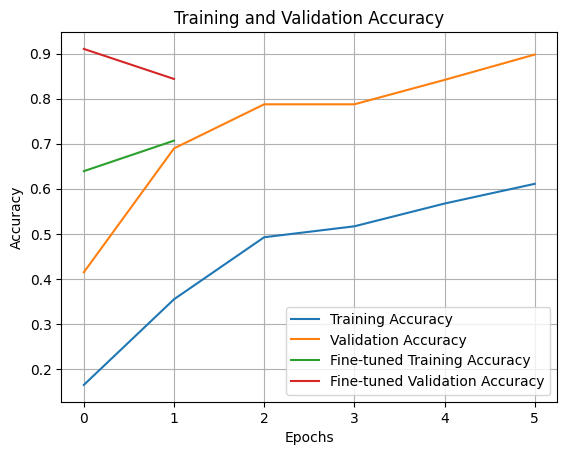

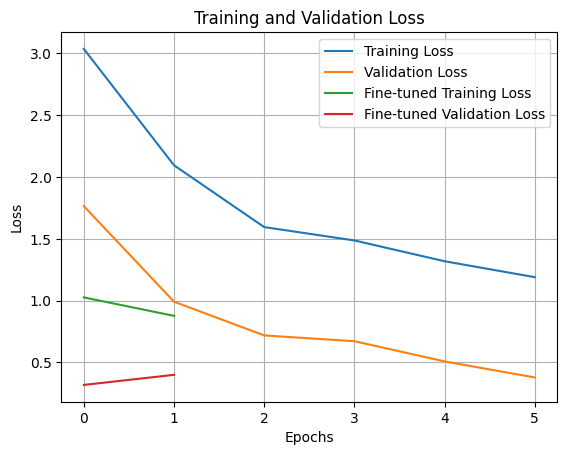

In [11]:
# Plot accuracy and loss curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuned Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tuned Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-tuned Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tuned Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

### Explanation:

- `plt.plot`: Plots the accuracy and loss for training and validation over epochs.
  
- Visual comparison shows if the model is overfitting, underfitting, or learning effectively.


<h3>Task 9: Test model predictions on sample images and visualize results</h3>


**Explanation:** Makes predictions on a few test images and displays them with the model's predicted class.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


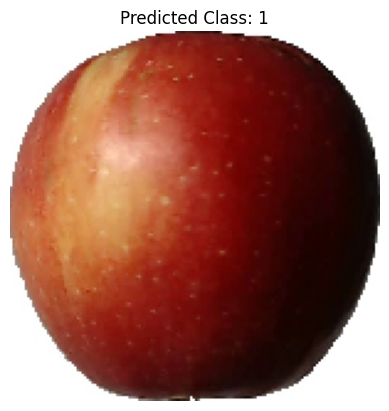

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


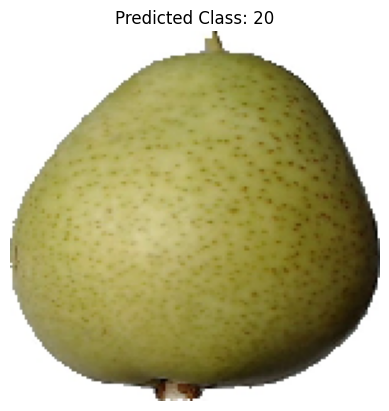

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


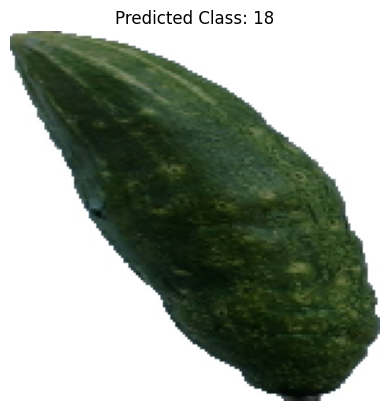

In [12]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Function to visualize a test image with prediction
def visualize_prediction(img_path):
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=-1)
    
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class[0]}")
    plt.axis('off')
    plt.show()

# Test on a few images
sample_images = [
    'fruits-360-original-size/fruits-360-original-size/Test/apple_braeburn_1/r0_11.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/pear_1/r0_103.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/cucumber_3/r0_103.jpg',
]

for img_path in sample_images:
    visualize_prediction(img_path)


### Explanation:

- `visualize_prediction`: Loads an image, preprocesses it, predicts its class, and displays it.
  
- `model.predict(img_array)`: Uses the trained model to make predictions on unseen images.


### Conclusion 


In this lab, you implemented a fruit classification model using transfer learning with VGG16. By fine-tuning and using data augmentation, you developed a robust classifier that can recognize different fruits. This lab demonstrated the efficiency of transfer learning in achieving high accuracy with minimal training data.


### Author

Skills Network


Copyright © IBM Corporation. All rights reserved.
